In [133]:
from ruzicka.Order2Verifier import Order2Verifier
from ruzicka.utilities import load_ground_truth, load_pan_dataset
from ruzicka.score_shifting import ScoreShifter
from ruzicka.BDIVerifier import BDIVerifier

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score

import pan20_verif_evaluator

import ray

from collections import defaultdict
from typing import Collection
import os
import pandas as pd
import numpy as np

In [134]:
%reload_ext rpy2.ipython

In [135]:
def pan21_overall(predicted, gt: Collection[float]) -> float:
    return pan20_verif_evaluator.evaluate_all(gt, predicted)["overall"]

In [136]:
def pan14_overall(predicted, gt: Collection[float]) -> float:
    res = pan20_verif_evaluator.evaluate_all(gt, predicted)
    return res["auc"] * res["c@1"]

In [137]:
PREFIX = "data/2014/"
CORPORA = [
    "du_essays",
    "du_reviews",
    "en_essays",
    "en_novels",
    "gr_articles",
    "sp_articles",
]

In [138]:
vectorizer_24 = make_pipeline(
    TfidfVectorizer(
        sublinear_tf=True,
        use_idf=False,
        norm="l2",
        analyzer="char",
        ngram_range=(2, 4),
        max_features=10000,
    ),
    # don't centre for minmax metric! cosine doesn't care
    StandardScaler(with_mean=False),
    FunctionTransformer(lambda x: np.asarray(x.todense()), accept_sparse=True),
)

vectorizer_25 = make_pipeline(
    TfidfVectorizer(
        sublinear_tf=True,
        use_idf=False,
        norm="l2",
        analyzer="char",
        ngram_range=(2, 5),
        max_features=10000,
    ),
    StandardScaler(with_mean=False),
    FunctionTransformer(lambda x: np.asarray(x.todense()), accept_sparse=True),
)

In [139]:
def recursive_dd():
    return defaultdict(recursive_dd)

In [140]:
corpus_hsh = recursive_dd()
for corpus in CORPORA:

    # DEV / FITTING DATA

    # this function is specific to the PAN2014 dataset format
    dev_train_data, dev_test_data = load_pan_dataset(
        os.path.join(PREFIX, corpus, "train")
    )
    dev_train_labels, dev_train_documents = zip(*dev_train_data)
    dev_test_labels, dev_test_documents = zip(*dev_test_data)

    corpus_hsh[corpus]["dev"]["vectorizer_24"]["train_X"] = vectorizer_24.fit_transform(
        dev_train_documents
    )
    corpus_hsh[corpus]["dev"]["vectorizer_24"]["test_X"] = vectorizer_24.transform(
        dev_test_documents
    )

    corpus_hsh[corpus]["dev"]["vectorizer_25"]["train_X"] = vectorizer_25.fit_transform(
        dev_train_documents
    )
    corpus_hsh[corpus]["dev"]["vectorizer_25"]["test_X"] = vectorizer_25.transform(
        dev_test_documents
    )

    label_encoder = LabelEncoder()
    label_encoder.fit(dev_train_labels + dev_test_labels)
    dev_train_y = np.array(label_encoder.transform(dev_train_labels), dtype="int")
    dev_test_y = np.array(label_encoder.transform(dev_test_labels), dtype="int")
    corpus_hsh[corpus]["dev"]["train_y"] = np.array(dev_train_y)
    corpus_hsh[corpus]["dev"]["test_y"] = np.array(dev_test_y)

    corpus_hsh[corpus]["dev"]["gt"] = np.array(
        # specific PAN14 function
        load_ground_truth(
            filepath=os.path.join(PREFIX, corpus, "train", "truth.txt"),
            labels=dev_test_labels,
        )
    )

    # EVAL DATA

    eval_train_data, eval_test_data = load_pan_dataset(
        os.path.join(PREFIX, corpus, "test")
    )
    eval_train_labels, eval_train_documents = zip(*eval_train_data)
    eval_test_labels, eval_test_documents = zip(*eval_test_data)

    # DO NOT refit the vectorizers here, so our z-scaling doesn't cheat by using eval data.
    corpus_hsh[corpus]["eval"]["vectorizer_24"]["train_X"] = vectorizer_24.transform(
        eval_train_documents
    )
    corpus_hsh[corpus]["eval"]["vectorizer_24"]["test_X"] = vectorizer_24.transform(
        eval_test_documents
    )

    corpus_hsh[corpus]["eval"]["vectorizer_25"]["train_X"] = vectorizer_25.transform(
        eval_train_documents
    )
    corpus_hsh[corpus]["eval"]["vectorizer_25"]["test_X"] = vectorizer_25.transform(
        eval_test_documents
    )

    label_encoder = LabelEncoder()
    label_encoder.fit(eval_train_labels + eval_test_labels)
    eval_train_y = np.array(label_encoder.transform(eval_train_labels), dtype="int")
    eval_test_y = np.array(label_encoder.transform(eval_test_labels), dtype="int")
    corpus_hsh[corpus]["eval"]["train_y"] = np.array(eval_train_y)
    corpus_hsh[corpus]["eval"]["test_y"] = np.array(eval_test_y)

    corpus_hsh[corpus]["eval"]["gt"] = np.array(
        load_ground_truth(
            filepath=os.path.join(PREFIX, corpus, "test", "truth.txt"),
            labels=eval_test_labels,
        )
    )

In [141]:
def precision(true_y, pred_y):
    """
    Assesses verification performance, assuming that every
    `score > 0.5` represents a same-author pair decision.
    Note that all non-decisions (scores == 0.5) are ignored
    by this metric.

    Parameters
    ----------
    prediction_scores : array [n_problems]

        The predictions outputted by a verification system.
        Assumes `0 >= prediction <=1`.

    ground_truth_scores : array [n_problems]

        The gold annotations provided for each problem.
        Will typically be `0` or `1`.

    Returns
    ----------
    acc = The number of correct attributions.

    References
    ----------
        E. Stamatatos, et al. Overview of the Author Identification
        Task at PAN 2014. CLEF (Working Notes) 2014: 877-897.
    """
    true_y_filtered, pred_y_filtered = [], []

    for true, pred in zip(true_y, pred_y):
        if pred != 0.5:
            true_y_filtered.append(true)
            pred_y_filtered.append(pred)

    pred_y_filtered = pan20_verif_evaluator.binarize(pred_y_filtered)

    return precision_score(true_y_filtered, pred_y_filtered)

In [142]:
@ray.remote
def evaluate(
    corpus_hsh: dict,
    corpus: str,
    phase: str,
    vectorizer: str,
    verifier: "Order2Verifier | BDIVerifier",
    shifter: "ScoreShifter | str",
    imposters: int,
):
    train_y = corpus_hsh[corpus][phase]["train_y"]
    test_y = corpus_hsh[corpus][phase]["test_y"]
    train_X = corpus_hsh[corpus][phase][vectorizer]["train_X"]
    test_X = corpus_hsh[corpus][phase][vectorizer]["test_X"]
    verifier.fit(train_X, train_y)
    test_scores = verifier.predict_proba(
        test_X=test_X, test_y=test_y, nb_imposters=imposters
    )
    gt_scores = np.array(corpus_hsh[corpus][phase]["gt"])
    if shifter == "fit":
        # weird numbers to stop the grid search rounding to suspiciously precise values
        shifter = ScoreShifter(min=0.053, max=0.947, min_spread=0.15)
        shifter.fit(
            predicted_scores=test_scores,
            ground_truth_scores=gt_scores,
            obj_func=pan14_overall,
        )
    assert isinstance(shifter, ScoreShifter)
    unanswered = (
        (shifter.optimal_p1 < test_scores) & (test_scores < shifter.optimal_p2)
    ).sum()
    high_conf = ((0.055 > test_scores) | (test_scores > 0.945)).sum()
    test_scores = np.array(shifter.transform(test_scores))
    fps = ((test_scores - gt_scores) > 0.5).sum()
    pan_dict = pan20_verif_evaluator.evaluate_all(gt_scores, test_scores)
    pan_dict["pan14_overall"] = pan14_overall(test_scores, gt_scores)
    return (
        {
            "tests": len(test_scores),
            "unanswered": unanswered,
            "high_conf": high_conf,
            "p1": shifter.optimal_p1,
            "p2": shifter.optimal_p2,
            "fp": fps,
            "prec": precision(gt_scores, test_scores),
        }
        | pan_dict,
        (test_scores, gt_scores),
    )

In [145]:
o2v_mm_param = {
    "metric": "minmax",
    "base": "instance",
    "rank": True,
    "nb_bootstrap_iter": 500,
    "rnd_prop": 0.5,
}
o2v_cs_param = {
    "metric": "cosine",
    "base": "instance",
    "rank": True,
    "nb_bootstrap_iter": 500,
    "rnd_prop": 0.5,
}

bdi_mm_param = {"metric": "minmax", "nb_bootstrap_iter": 500, "rnd_prop": 0.5}
bdi_cs_param = {"metric": "cosine", "nb_bootstrap_iter": 500, "rnd_prop": 0.5}

classifs = [
    ("Kestemont GI, Minmax", Order2Verifier, o2v_mm_param),
    ("Kestemont GI, Cosine", Order2Verifier, o2v_cs_param),
    ("BDI, Minmax", BDIVerifier, bdi_mm_param),
    ("BDI, Cosine", BDIVerifier, bdi_cs_param),
]

In [144]:
c_hash = ray.put(corpus_hsh)

In [17]:
r = evaluate.remote(
    c_hash,
    "du_essays",
    "eval",
    "vectorizer_24",
    classifs[0][1](**o2v_mm_param),
    "fit",
    30,
)

In [18]:
ray.get(r)

({'tests': 96,
  'unanswered': 6,
  'high_conf': 53,
  'p1': 0.61622,
  'p2': 0.7682,
  'fp': 2,
  'prec': 0.9565217391304348,
  'auc': 0.966,
  'c@1': 0.963,
  'f_05_u': 0.936,
  'F1': 0.967,
  'brier': 0.938,
  'overall': 0.954,
  'pan14_overall': 0.9302579999999999},
 (array([0.99999785, 0.99999785, 0.99353972, 0.99999785, 0.04509785,
         0.15686192, 0.11321723, 0.9422335 , 0.10269753, 0.03660813,
         0.99999785, 0.06746874, 0.03991159, 0.78795605, 0.0341567 ,
         0.99999785, 0.89630905, 0.99999785, 0.96483694, 0.9892343 ,
         0.87851333, 0.5       , 0.31179727, 0.99999785, 0.5       ,
         0.0352739 , 0.9892343 , 0.99999785, 0.99999785, 0.99999785,
         0.41787445, 0.44368569, 0.14879289, 0.99999785, 0.99999785,
         0.93541659, 0.99999785, 0.5       , 0.08406345, 0.11228733,
         0.99999785, 0.58179833, 0.99569243, 0.5       , 0.99784514,
         0.04450987, 0.99569243, 0.94187472, 0.06951683, 0.99999785,
         0.09018816, 0.05422184, 0.0338

In [146]:
remotes = []
fit_labels = []
rs = np.random.RandomState(42)

for corpus in CORPORA:
    for classif_name, classifier, params in classifs:
        for vec_name in ["vectorizer_24", "vectorizer_25"]:
            remotes.append(
                evaluate.remote(
                    c_hash,
                    corpus,
                    "dev",
                    vec_name,
                    classifier(**params | {"random_state": rs.randint(2**32 - 1)}),
                    ScoreShifter().manual_fit(0.11, 0.89),
                    30,
                )
            )

            fit_labels.append(
                {
                    "classifier": f"{classif_name} + {vec_name} + manual",
                    "corpus": corpus,
                }
            )

            remotes.append(
                evaluate.remote(
                    c_hash,
                    corpus,
                    "dev",
                    vec_name,
                    classifier(**params | {"random_state": rs.randint(2**32 - 1)}),
                    "fit",
                    30,
                )
            )
            fit_labels.append(
                {
                    "classifier": f"{classif_name} + {vec_name} + fitted",
                    "corpus": corpus,
                }
            )

fit_remotes_res = ray.get(remotes)

In [20]:
fit_results = pd.DataFrame([a[0] | b for a, b in zip(fit_remotes_res, fit_labels)])
fit_results.sort_values(by="pan14_overall", ascending=False)

,tests,unanswered,high_conf,p1,p2,fp,prec,auc,c@1,f_05_u,F1,brier,overall,pan14_overall,classifier,corpus
13,96,3,80,0.28544,0.43742,4,0.921569,0.952,0.956,0.925,0.959,0.939,0.946,0.910112,"BDI, Cosine + vectorizer_24 + fitted",du_essays
15,96,5,79,0.12452,0.53576,4,0.920000,0.954,0.953,0.916,0.958,0.934,0.943,0.909162,"BDI, Cosine + vectorizer_25 + fitted",du_essays
1,96,9,49,0.35696,0.92018,3,0.933333,0.949,0.957,0.909,0.966,0.918,0.940,0.908193,"Kestemont GI, Minmax + vectorizer_24 + fitted",du_essays
9,96,5,84,0.12452,0.69668,4,0.918367,0.952,0.953,0.915,0.957,0.938,0.943,0.907256,"BDI, Minmax + vectorizer_24 + fitted",du_essays
3,96,5,53,0.27650,0.77714,4,0.920000,0.952,0.953,0.916,0.958,0.920,0.940,0.907256,"Kestemont GI, Minmax + vectorizer_25 + fitted",du_essays
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,100,73,14,0.11000,0.89000,5,0.761905,0.634,0.363,0.460,0.842,0.761,0.612,0.230142,"Kestemont GI, Minmax + vectorizer_24 + manual",sp_articles
34,200,143,16,0.11000,0.89000,5,0.500000,0.566,0.292,0.121,0.303,0.755,0.407,0.165272,"Kestemont GI, Minmax + vectorizer_25 + manual",en_essays
32,200,148,11,0.11000,0.89000,4,0.555556,0.569,0.278,0.122,0.333,0.761,0.413,0.158182,"Kestemont GI, Minmax + vectorizer_24 + manual",en_essays
38,200,146,18,0.11000,0.89000,4,0.500000,0.557,0.277,0.100,0.267,0.751,0.390,0.154289,"Kestemont GI, Cosine + vectorizer_25 + manual",en_essays


In [147]:
fit_results = pd.DataFrame([a[0] | b for a, b in zip(fit_remotes_res, fit_labels)])
fit_results.sort_values(by="pan14_overall", ascending=False)

,tests,unanswered,high_conf,p1,p2,fp,prec,auc,c@1,f_05_u,F1,brier,overall,pan14_overall,classifier,corpus
13,96,4,81,0.29438,0.44636,4,0.921569,0.955,0.955,0.922,0.959,0.940,0.946,0.912025,"BDI, Cosine + vectorizer_24 + fitted",du_essays
9,96,5,86,0.10664,0.71456,4,0.918367,0.956,0.953,0.915,0.957,0.937,0.944,0.911068,"BDI, Minmax + vectorizer_24 + fitted",du_essays
1,96,9,49,0.35696,0.92018,3,0.933333,0.949,0.957,0.909,0.966,0.918,0.940,0.908193,"Kestemont GI, Minmax + vectorizer_24 + fitted",du_essays
3,96,5,53,0.27650,0.77714,4,0.920000,0.952,0.953,0.916,0.958,0.920,0.940,0.907256,"Kestemont GI, Minmax + vectorizer_25 + fitted",du_essays
8,96,6,87,0.11000,0.89000,4,0.916667,0.953,0.952,0.909,0.957,0.936,0.941,0.907256,"BDI, Minmax + vectorizer_24 + manual",du_essays
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,100,73,14,0.11000,0.89000,5,0.761905,0.634,0.363,0.460,0.842,0.761,0.612,0.230142,"Kestemont GI, Minmax + vectorizer_24 + manual",sp_articles
34,200,143,16,0.11000,0.89000,5,0.500000,0.566,0.292,0.121,0.303,0.755,0.407,0.165272,"Kestemont GI, Minmax + vectorizer_25 + manual",en_essays
32,200,148,11,0.11000,0.89000,4,0.555556,0.569,0.278,0.122,0.333,0.761,0.413,0.158182,"Kestemont GI, Minmax + vectorizer_24 + manual",en_essays
38,200,146,18,0.11000,0.89000,4,0.500000,0.557,0.277,0.100,0.267,0.751,0.390,0.154289,"Kestemont GI, Cosine + vectorizer_25 + manual",en_essays


In [16]:
fit_results.to_csv("fit_results.csv")

In [17]:
fit_results = pd.read_csv("fit_results.csv", index_col=0)
fit_results

,tests,unanswered,high_conf,p1,p2,fp,prec,auc,c@1,f_05_u,F1,brier,overall,pan14_overall,classifier,corpus
0,96,25,50,0.11000,0.89000,4,0.916667,0.930,0.880,0.843,0.957,0.865,0.895,0.818400,"Kestemont GI, Minmax + vectorizer_24 + manual",du_essays
1,96,9,49,0.35696,0.92018,3,0.933333,0.949,0.957,0.909,0.966,0.918,0.940,0.908193,"Kestemont GI, Minmax + vectorizer_24 + fitted",du_essays
2,96,25,53,0.11000,0.89000,4,0.914894,0.923,0.880,0.840,0.956,0.864,0.893,0.812240,"Kestemont GI, Minmax + vectorizer_25 + manual",du_essays
3,96,5,53,0.27650,0.77714,4,0.920000,0.952,0.953,0.916,0.958,0.920,0.940,0.907256,"Kestemont GI, Minmax + vectorizer_25 + fitted",du_essays
4,96,26,48,0.11000,0.89000,3,0.933333,0.926,0.887,0.847,0.966,0.862,0.898,0.821362,"Kestemont GI, Cosine + vectorizer_24 + manual",du_essays
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,100,12,45,0.07982,0.23180,8,0.822222,0.836,0.818,0.784,0.831,0.835,0.821,0.683848,"BDI, Minmax + vectorizer_25 + fitted",sp_articles
92,100,41,47,0.11000,0.89000,5,0.705882,0.801,0.677,0.472,0.686,0.814,0.690,0.542277,"BDI, Cosine + vectorizer_24 + manual",sp_articles
93,100,12,49,0.05300,0.20498,8,0.833333,0.827,0.851,0.806,0.870,0.837,0.838,0.703777,"BDI, Cosine + vectorizer_24 + fitted",sp_articles
94,100,42,48,0.11000,0.89000,2,0.857143,0.825,0.710,0.517,0.750,0.811,0.723,0.585750,"BDI, Cosine + vectorizer_25 + manual",sp_articles


In [148]:
remotes = []
eval_labels = []
rs = np.random.RandomState(42)

for corpus in CORPORA:
    for classif_name, classifier, params in classifs:
        for vec_name in ["vectorizer_24", "vectorizer_25"]:
            remotes.append(
                evaluate.remote(
                    c_hash,
                    corpus,
                    "eval",
                    vec_name,
                    classifier(**params | {"random_state": rs.randint(2**32 - 1)}),
                    ScoreShifter().manual_fit(0.11, 0.89),
                    30,
                )
            )

            eval_labels.append(
                {
                    "classifier": f"{classif_name} + {vec_name} + manual",
                    "corpus": corpus,
                }
            )

            fit_label = f"{classif_name} + {vec_name} + fitted"
            p1 = fit_results[
                (fit_results.classifier == fit_label) & (fit_results.corpus == corpus)
            ]["p1"].iloc[0]
            p2 = fit_results[
                (fit_results.classifier == fit_label) & (fit_results.corpus == corpus)
            ]["p2"].iloc[0]
            remotes.append(
                evaluate.remote(
                    c_hash,
                    corpus,
                    "eval",
                    vec_name,
                    classifier(**params | {"random_state": rs.randint(2**32 - 1)}),
                    ScoreShifter().manual_fit(p1, p2),
                    30,
                )
            )
            eval_labels.append(
                {
                    "classifier": f"{classif_name} + {vec_name} + fitted",
                    "corpus": corpus,
                }
            )

eval_remotes_res = ray.get(remotes)

In [149]:
result_df = pd.DataFrame([a[0] | b for a, b in zip(eval_remotes_res, eval_labels)])

In [20]:
result_df.to_csv("eval_results.csv")

In [23]:
result_df.sort_values(by="overall", ascending=False)

,tests,unanswered,high_conf,p1,p2,fp,prec,auc,c@1,f_05_u,F1,brier,overall,pan14_overall,classifier,corpus
7,96,7,49,0.46424,0.63410,4,0.918367,0.965,0.939,0.904,0.947,0.930,0.937,0.906135,"Kestemont GI, Cosine + vectorizer_25 + fitted",du_essays
1,96,17,54,0.35696,0.92018,2,0.954545,0.954,0.944,0.894,0.977,0.919,0.937,0.900576,"Kestemont GI, Minmax + vectorizer_24 + fitted",du_essays
12,96,19,72,0.11000,0.89000,2,0.951220,0.957,0.936,0.878,0.975,0.920,0.933,0.895752,"BDI, Cosine + vectorizer_24 + manual",du_essays
11,96,18,75,0.09770,0.78608,2,0.953488,0.958,0.928,0.884,0.965,0.921,0.931,0.889024,"BDI, Minmax + vectorizer_25 + fitted",du_essays
3,96,17,52,0.27650,0.77714,3,0.934783,0.953,0.932,0.881,0.966,0.918,0.930,0.888196,"Kestemont GI, Minmax + vectorizer_25 + fitted",du_essays
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36,200,150,14,0.11000,0.89000,1,0.800000,0.573,0.280,0.105,0.308,0.759,0.405,0.160440,"Kestemont GI, Cosine + vectorizer_24 + manual",en_essays
22,50,19,14,0.11000,0.89000,0,1.000000,0.558,0.469,0.132,0.125,0.733,0.403,0.261702,"Kestemont GI, Cosine + vectorizer_25 + manual",du_reviews
46,200,24,161,0.11000,0.89000,0,1.000000,0.591,0.543,0.163,0.092,0.618,0.401,0.320913,"BDI, Cosine + vectorizer_25 + manual",en_essays
30,50,12,37,0.11000,0.89000,0,1.000000,0.566,0.521,0.147,0.105,0.605,0.389,0.294886,"BDI, Cosine + vectorizer_25 + manual",du_reviews


In [151]:
result_df.sort_values(by="overall", ascending=False)

,tests,unanswered,high_conf,p1,p2,fp,prec,auc,c@1,f_05_u,F1,brier,overall,pan14_overall,classifier,corpus
12,96,18,76,0.11000,0.89000,2,0.952381,0.961,0.940,0.885,0.976,0.928,0.938,0.903340,"BDI, Cosine + vectorizer_24 + manual",du_essays
7,96,7,49,0.46424,0.63410,4,0.918367,0.965,0.939,0.904,0.947,0.930,0.937,0.906135,"Kestemont GI, Cosine + vectorizer_25 + fitted",du_essays
1,96,17,54,0.35696,0.92018,2,0.954545,0.954,0.944,0.894,0.977,0.919,0.937,0.900576,"Kestemont GI, Minmax + vectorizer_24 + fitted",du_essays
3,96,17,52,0.27650,0.77714,3,0.934783,0.953,0.932,0.881,0.966,0.918,0.930,0.888196,"Kestemont GI, Minmax + vectorizer_25 + fitted",du_essays
9,96,11,73,0.10664,0.71456,4,0.918367,0.959,0.929,0.889,0.947,0.927,0.930,0.890911,"BDI, Minmax + vectorizer_24 + fitted",du_essays
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37,200,10,14,0.54470,0.69668,12,0.428571,0.504,0.478,0.237,0.154,0.653,0.405,0.240912,"Kestemont GI, Cosine + vectorizer_24 + fitted",en_essays
36,200,150,14,0.11000,0.89000,1,0.800000,0.573,0.280,0.105,0.308,0.759,0.405,0.160440,"Kestemont GI, Cosine + vectorizer_24 + manual",en_essays
22,50,19,14,0.11000,0.89000,0,1.000000,0.558,0.469,0.132,0.125,0.733,0.403,0.261702,"Kestemont GI, Cosine + vectorizer_25 + manual",du_reviews
46,200,26,162,0.11000,0.89000,0,1.000000,0.569,0.542,0.161,0.093,0.612,0.396,0.308398,"BDI, Cosine + vectorizer_25 + manual",en_essays


In [152]:
result_df.groupby(["corpus", "classifier"]).agg("sum").sort_values(
    by="overall", ascending=False
).query("corpus=='en_novels'")

tests  unanswered  \
corpus    classifier                                                         
en_novels Kestemont GI, Cosine + vectorizer_24 + fitted    200          74   
          Kestemont GI, Minmax + vectorizer_24 + fitted    200          72   
          Kestemont GI, Cosine + vectorizer_25 + fitted    200          72   
          Kestemont GI, Minmax + vectorizer_25 + fitted    200          42   
          BDI, Minmax + vectorizer_24 + fitted             200           6   
          BDI, Cosine + vectorizer_24 + fitted             200           8   
          BDI, Minmax + vectorizer_25 + fitted             200          10   
          BDI, Cosine + vectorizer_25 + fitted             200          12   
          Kestemont GI, Cosine + vectorizer_25 + manual    200          64   
          Kestemont GI, Cosine + vectorizer_24 + manual    200          69   
          Kestemont GI, Minmax + vectorizer_25 + manual    200          65   
          Kestemont GI, Minmax + vectorizer_24 + manual    200          67   
          BDI, Cosine + vectorizer_25 + manual             200          27   
          BDI, Minmax + vectorizer_25 + manual             200          26   
          BDI, Cosine + vectorizer_24 + manual             200          28   
          BDI, Minmax + vectorizer_24 + manual             200          30   

                                                         high_conf       p1  \
corpus    classifier                                                          
en_novels Kestemont GI, Cosine + vectorizer_24 + fitted         74  0.06194   
          Kestemont GI, Minmax + vectorizer_24 + fitted         76  0.06194   
          Kestemont GI, Cosine + vectorizer_25 + fitted         80  0.06194   
          Kestemont GI, Minmax + vectorizer_25 + fitted         79  0.08876   
          BDI, Minmax + vectorizer_24 + fitted                 164  0.05300   
          BDI, Cosine + vectorizer_24 + fitted                 166  0.05300   
          BDI, Minmax + vectorizer_25 + fitted                 165  0.05300   
          BDI, Cosine + vectorizer_25 + fitted                 164  0.05300   
          Kestemont GI, Cosine + vectorizer_25 + manual         78  0.11000   
          Kestemont GI, Cosine + vectorizer_24 + manual         76  0.11000   
          Kestemont GI, Minmax + vectorizer_25 + manual         80  0.11000   
          Kestemont GI, Minmax + vectorizer_24 + manual         76  0.11000   
          BDI, Cosine + vectorizer_25 + manual                 168  0.11000   
          BDI, Minmax + vectorizer_25 + manual                 165  0.11000   
          BDI, Cosine + vectorizer_24 + manual                 164  0.11000   
          BDI, Minmax + vectorizer_24 + manual                 164  0.11000   

                                                              p2  fp  \
corpus    classifier                                                   
en_novels Kestemont GI, Cosine + vectorizer_24 + fitted  0.21392   7   
          Kestemont GI, Minmax + vectorizer_24 + fitted  0.21392   8   
          Kestemont GI, Cosine + vectorizer_25 + fitted  0.21392   6   
          Kestemont GI, Minmax + vectorizer_25 + fitted  0.24074   6   
          BDI, Minmax + vectorizer_24 + fitted           0.20498   3   
          BDI, Cosine + vectorizer_24 + fitted           0.20498   3   
          BDI, Minmax + vectorizer_25 + fitted           0.20498   2   
          BDI, Cosine + vectorizer_25 + fitted           0.20498   3   
          Kestemont GI, Cosine + vectorizer_25 + manual  0.89000   1   
          Kestemont GI, Cosine + vectorizer_24 + manual  0.89000   0   
          Kestemont GI, Minmax + vectorizer_25 + manual  0.89000   1   
          Kestemont GI, Minmax + vectorizer_24 + manual  0.89000   0   
          BDI, Cosine + vectorizer_25 + manual           0.89000   0   
          BDI, Minmax + vectorizer_25 + manual           0.89000   0   
          BDI, Cosine + vectorizer_24 + manual           0.89000   1   
     

In [65]:
result_df.query("classifier=='Kestemont GI, Minmax + vectorizer_25 + fitted'")

,tests,unanswered,high_conf,p1,p2,fp,prec,auc,c@1,f_05_u,F1,brier,overall,pan14_overall,classifier,corpus
3,96,17,52,0.27650,0.77714,3,0.934783,0.953,0.932,0.881,0.966,0.918,0.930,0.888196,"Kestemont GI, Minmax + vectorizer_25 + fitted",du_essays
19,50,11,13,0.12452,0.28544,4,0.666667,0.624,0.561,0.506,0.500,0.746,0.587,0.350064,"Kestemont GI, Minmax + vectorizer_25 + fitted",du_reviews
35,200,19,25,0.52682,0.67880,8,0.555556,0.559,0.498,0.273,0.182,0.665,0.435,0.278382,"Kestemont GI, Minmax + vectorizer_25 + fitted",en_essays
51,200,42,79,0.08876,0.24074,6,0.863636,0.683,0.641,0.629,0.594,0.774,0.664,0.437803,"Kestemont GI, Minmax + vectorizer_25 + fitted",en_novels
67,100,29,19,0.47318,0.84866,3,0.857143,0.839,0.735,0.634,0.720,0.820,0.750,0.616665,"Kestemont GI, Minmax + vectorizer_25 + fitted",gr_articles
83,100,13,28,0.42848,0.64304,8,0.849057,0.934,0.848,0.821,0.882,0.881,0.873,0.792032,"Kestemont GI, Minmax + vectorizer_25 + fitted",sp_articles


In [77]:
def global_micro(remotes_res, labels):
    d = defaultdict(lambda: [[], []])
    for (hsh, (pred, gt)), label in zip(remotes_res, labels):
        d[label["classifier"]][0].extend(pred)
        d[label["classifier"]][1].extend(gt)

    hh = []
    for k in d.keys():
        hsh = {"classifier": k}
        hsh |= pan20_verif_evaluator.evaluate_all(d[k][1], d[k][0])
        hsh["prec"] = precision(d[k][1], d[k][0])
        hsh["pan14_overall"] = pan14_overall(*d[k])
        hh.append(hsh)

    return pd.DataFrame(hh)

In [78]:
gmicro = global_micro(eval_remotes_res, eval_labels)
gmicro.to_csv("global_micro.csv")
gmicro

,classifier,auc,c@1,f_05_u,F1,brier,overall,prec,pan14_overall
0,"Kestemont GI, Minmax + vectorizer_24 + manual",0.703,0.562,0.515,0.719,0.788,0.658,0.929204,0.395086
1,"Kestemont GI, Minmax + vectorizer_24 + fitted",0.721,0.666,0.652,0.649,0.784,0.694,0.808612,0.480186
2,"Kestemont GI, Minmax + vectorizer_25 + manual",0.700,0.568,0.513,0.700,0.785,0.653,0.912281,0.397600
3,"Kestemont GI, Minmax + vectorizer_25 + fitted",0.723,0.674,0.662,0.634,0.782,0.695,0.835052,0.487302
4,"Kestemont GI, Cosine + vectorizer_24 + manual",0.693,0.548,0.498,0.714,0.784,0.647,0.925926,0.379764
5,"Kestemont GI, Cosine + vectorizer_24 + fitted",0.715,0.664,0.645,0.642,0.780,0.689,0.778281,0.474760
6,"Kestemont GI, Cosine + vectorizer_25 + manual",0.689,0.548,0.500,0.699,0.783,0.644,0.918182,0.377572
7,"Kestemont GI, Cosine + vectorizer_25 + fitted",0.723,0.673,0.660,0.650,0.784,0.698,0.787611,0.486579
8,"BDI, Minmax + vectorizer_24 + manual",0.731,0.663,0.551,0.500,0.728,0.634,0.956044,0.484653
9,"BDI, Minmax + vectorizer_24 + fitted",0.737,0.706,0.707,0.632,0.739,0.704,0.845771,0.520322


In [79]:
gmicro.sort_values(by="pan14_overall", ascending=False)

,classifier,auc,c@1,f_05_u,F1,brier,overall,prec,pan14_overall
9,"BDI, Minmax + vectorizer_24 + fitted",0.737,0.706,0.707,0.632,0.739,0.704,0.845771,0.520322
11,"BDI, Minmax + vectorizer_25 + fitted",0.731,0.703,0.694,0.625,0.738,0.698,0.851852,0.513893
13,"BDI, Cosine + vectorizer_24 + fitted",0.729,0.691,0.678,0.611,0.735,0.689,0.820513,0.503739
15,"BDI, Cosine + vectorizer_25 + fitted",0.718,0.696,0.686,0.616,0.731,0.689,0.849462,0.499728
3,"Kestemont GI, Minmax + vectorizer_25 + fitted",0.723,0.674,0.662,0.634,0.782,0.695,0.835052,0.487302
10,"BDI, Minmax + vectorizer_25 + manual",0.732,0.665,0.555,0.493,0.722,0.633,0.936170,0.486780
7,"Kestemont GI, Cosine + vectorizer_25 + fitted",0.723,0.673,0.660,0.650,0.784,0.698,0.787611,0.486579
8,"BDI, Minmax + vectorizer_24 + manual",0.731,0.663,0.551,0.500,0.728,0.634,0.956044,0.484653
1,"Kestemont GI, Minmax + vectorizer_24 + fitted",0.721,0.666,0.652,0.649,0.784,0.694,0.808612,0.480186
12,"BDI, Cosine + vectorizer_24 + manual",0.727,0.655,0.525,0.478,0.724,0.622,0.952381,0.476185


In [26]:
bdi_mmc_param = {
    "metric": "minmax",
    "nb_bootstrap_iter": 500,
    "rnd_prop": 0.33,
    "method": "closest",
}

o2v_mmu_param = {
    "metric": "minmax",
    "base": "instance",
    "rank": False,
    "nb_bootstrap_iter": 500,
    "rnd_prop": 0.5,
}

bdi_csc_param = {
    "metric": "cosine",
    "nb_bootstrap_iter": 500,
    "rnd_prop": 0.33,
    "method": "closest",
}

o2v_csu_param = {
    "metric": "cosine",
    "base": "instance",
    "rank": False,
    "nb_bootstrap_iter": 500,
    "rnd_prop": 0.5,
}

unranked_classifs = [
    ("BDI, Minmax", BDIVerifier, bdi_mmc_param),
    ("Kestemont GI, Minmax", Order2Verifier, o2v_mmu_param),
    ("Kestemont GI, Cosine", Order2Verifier, o2v_csu_param),
    ("BDI, Cosine", BDIVerifier, bdi_csc_param),
]

In [27]:
remotes = []
unranked_labels = []
rs = np.random.RandomState(42)

for corpus in CORPORA:
    for classif_name, classifier, params in unranked_classifs:
        for vec_name in ["vectorizer_24", "vectorizer_25"]:
            remotes.append(
                evaluate.remote(
                    c_hash,
                    corpus,
                    "eval",
                    vec_name,
                    classifier(**params | {"random_state": rs.randint(2**32 - 1)}),
                    ScoreShifter().manual_fit(0.11, 0.89),
                    30,
                )
            )

            unranked_labels.append(
                {
                    "classifier": f"{classif_name} + {vec_name} + manual",
                    "corpus": corpus,
                }
            )

            fit_label = f"{classif_name} + {vec_name} + fitted"
            p1 = fit_results[
                (fit_results.classifier == fit_label) & (fit_results.corpus == corpus)
            ]["p1"].iloc[0]
            p2 = fit_results[
                (fit_results.classifier == fit_label) & (fit_results.corpus == corpus)
            ]["p2"].iloc[0]
            remotes.append(
                evaluate.remote(
                    c_hash,
                    corpus,
                    "eval",
                    vec_name,
                    classifier(**params | {"random_state": rs.randint(2**32 - 1)}),
                    ScoreShifter().manual_fit(p1, p2),
                    30,
                )
            )
            unranked_labels.append(
                {
                    "classifier": f"{classif_name} + {vec_name} + fitted",
                    "corpus": corpus,
                }
            )

unranked_remotes_res = ray.get(remotes)

(evaluate pid=97610) /Users/ben/venv/cnns/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
(evaluate pid=97610)   _warn_prf(average, modifier, msg_start, len(result))
(evaluate pid=97606) /Users/ben/venv/cnns/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior. [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(evaluate pid=97606)   _warn_prf(average, modifier, msg_start, len(result)) [repeated 2x across cluster]
(evaluate pid=97611) /Users/ben/venv/cnns/lib

In [28]:
df = global_micro(unranked_remotes_res, unranked_labels)
df.sort_values(by="pan14_overall", ascending=False)

,classifier,auc,c@1,f_05_u,F1,brier,overall,prec,pan14_overall
1,"BDI, Minmax + vectorizer_24 + fitted",0.715,0.670,0.653,0.600,0.725,0.673,0.791045,0.479050
3,"BDI, Minmax + vectorizer_25 + fitted",0.705,0.667,0.631,0.599,0.725,0.665,0.768844,0.470235
15,"BDI, Cosine + vectorizer_25 + fitted",0.698,0.666,0.631,0.588,0.720,0.661,0.786096,0.464868
13,"BDI, Cosine + vectorizer_24 + fitted",0.701,0.661,0.623,0.585,0.724,0.659,0.748768,0.463361
11,"Kestemont GI, Cosine + vectorizer_25 + fitted",0.698,0.659,0.633,0.503,0.696,0.638,0.879699,0.459982
9,"Kestemont GI, Cosine + vectorizer_24 + fitted",0.702,0.652,0.602,0.474,0.699,0.626,0.895652,0.457704
7,"Kestemont GI, Minmax + vectorizer_25 + fitted",0.702,0.651,0.608,0.467,0.694,0.624,0.903509,0.457002
5,"Kestemont GI, Minmax + vectorizer_24 + fitted",0.705,0.647,0.606,0.465,0.697,0.624,0.903509,0.456135
2,"BDI, Minmax + vectorizer_25 + manual",0.700,0.634,0.493,0.457,0.712,0.599,0.937500,0.443800
0,"BDI, Minmax + vectorizer_24 + manual",0.703,0.619,0.481,0.464,0.713,0.596,0.948718,0.435157


In [29]:
unranked_df = pd.DataFrame(
    [a[0] | b for a, b in zip(unranked_remotes_res, unranked_labels)]
)

In [30]:
unranked_df.groupby(["corpus", "classifier"]).agg("sum").sort_values(
    by="overall", ascending=False
).query("prec==0")

tests  unanswered  \
corpus    classifier                                                         
en_novels BDI, Cosine + vectorizer_25 + manual             200          30   
          BDI, Cosine + vectorizer_24 + manual             200          33   
          BDI, Minmax + vectorizer_25 + manual             200          29   
          BDI, Minmax + vectorizer_24 + manual             200          32   
          Kestemont GI, Cosine + vectorizer_24 + manual    200          15   
          Kestemont GI, Cosine + vectorizer_25 + manual    200          13   
          Kestemont GI, Minmax + vectorizer_25 + manual    200          13   
          Kestemont GI, Minmax + vectorizer_24 + manual    200          14   

                                                         high_conf    p1  \
corpus    classifier                                                       
en_novels BDI, Cosine + vectorizer_25 + manual                 165  0.11   
          BDI, Cosine + vectorizer_24 + manual                 162  0.11   
          BDI, Minmax + vectorizer_25 + manual                 167  0.11   
          BDI, Minmax + vectorizer_24 + manual                 165  0.11   
          Kestemont GI, Cosine + vectorizer_24 + manual        175  0.11   
          Kestemont GI, Cosine + vectorizer_25 + manual        178  0.11   
          Kestemont GI, Minmax + vectorizer_25 + manual        179  0.11   
          Kestemont GI, Minmax + vectorizer_24 + manual        178  0.11   

                                                           p2  fp  prec  \
corpus    classifier                                                      
en_novels BDI, Cosine + vectorizer_25 + manual           0.89   0   0.0   
          BDI, Cosine + vectorizer_24 + manual           0.89   0   0.0   
          BDI, Minmax + vectorizer_25 + manual           0.89   0   0.0   
          BDI, Minmax + vectorizer_24 + manual           0.89   0   0.0   
          Kestemont GI, Cosine + vectorizer_24 + manual  0.89   0   0.0   
          Kestemont GI, Cosine + vectorizer_25 + manual  0.89   0   0.0   
          Kestemont GI, Minmax + vectorizer_25 + manual  0.89   0   0.0   
          Kestemont GI, Minmax + vectorizer_24 + manual  0.89   0   0.0   

                                                           auc    c@1  f_05_u  \
corpus    classifier                                                            
en_novels BDI, Cosine + vectorizer_25 + manual           0.683  0.558     0.0   
          BDI, Cosine + vectorizer_24 + manual           0.658  0.565     0.0   
          BDI, Minmax + vectorizer_25 + manual           0.671  0.561     0.0   
          BDI, Minmax + vectorizer_24 + manual           0.660  0.563     0.0   
          Kestemont GI, Cosine + vectorizer_24 + manual  0.669  0.532     0.0   
          Kestemont GI, Cosine + vectorizer_25 + manual  0.653  0.532     0.0   
          Kestemont GI, Minmax + vectorizer_25 + manual  0.647  0.532     0.0   
          Kestemont GI, Minmax + vectorizer_24 + manual  0.643  0.530     0.0   

                                                          F1  brier  overall  \
corpus    classifier                                                           
en_novels BDI, Cosine + vectorizer_25 + manual           0.0  0.616    0.371   
          BDI, Cosine + vectorizer_24 + manual           0.0  0.626    0.370   
          BDI, Minmax + vectorizer_25 + manual           0.0  0.615    0.369   
          BDI, Minmax + vectorizer_24 + manual           0.0  0.624    0.369   
          Kestemont GI, Cosine + vectorizer_24 + manual  0.0  0.594    0.359   
          Kestemont GI, Cosine + vectorizer_25 + manual  0.0  0.582    0.354   
          Kestemont GI, Minmax + vectorizer_25 + manual  0.0  0.581    0.352   
          Kestemont GI, Minmax + vectorizer_24 + manual  0.0  0.587    0.352   

                                                         pan14_overall  
corpus    classifier                                                    
en_nov

In [31]:
unranked_df.to_csv("unranked_results.csv")

In [33]:
df.to_csv("unranked_micro.csv")

In [33]:
probs, labs, gts = [], [], []
k = "Kestemont GI, Minmax + vectorizer_25 + fitted"
bdi = "BDI, Minmax + vectorizer_25 + manual"

for i in range(len(eval_remotes_res)):
    if eval_labels[i]["classifier"] == bdi:
        labs.extend(["BDI"] * len(eval_remotes_res[i][1][0]))
    elif eval_labels[i]["classifier"] == k:
        labs.extend(["O2V"] * len(eval_remotes_res[i][1][0]))
    else:
        continue
    probs.extend(eval_remotes_res[i][1][0])
    gts.extend(eval_remotes_res[i][1][1])

In [45]:
df = pd.DataFrame([probs, labs, gts]).T
df.columns = ["proba", "classif", "gt"]
df

,proba,classif,gt
0,0.999998,O2V,1.0
1,0.999998,O2V,1.0
2,0.968651,O2V,1.0
3,0.999998,O2V,1.0
4,0.097673,O2V,0.0
...,...,...,...
1487,0.990923,BDI,1.0
1488,0.0,BDI,0.0
1489,0.827615,BDI,1.0
1490,0.009073,BDI,0.0


In [58]:
def tfu(r):
    if r["proba"] == 0.5:
        return "U"
    elif (r["proba"] < 0.5) and r["gt"] == 0.0:
        return "T"
    elif (r["proba"] > 0.5) and r["gt"] == 1.0:
        return "T"
    else:
        return "F"


df["tfu"] = df.apply(tfu, axis=1)
df

,proba,classif,gt,tfu
0,0.999998,O2V,1.0,T
1,0.999998,O2V,1.0,T
2,0.968651,O2V,1.0,T
3,0.999998,O2V,1.0,T
4,0.097673,O2V,0.0,T
...,...,...,...,...
1487,0.990923,BDI,1.0,T
1488,0.000000,BDI,0.0,T
1489,0.827615,BDI,1.0,T
1490,0.009073,BDI,0.0,T


In [59]:
df["proba"] = pd.to_numeric(df["proba"])
df["gt"] = pd.to_numeric(df["gt"])

In [60]:
df

,proba,classif,gt,tfu
0,0.999998,O2V,1.0,T
1,0.999998,O2V,1.0,T
2,0.968651,O2V,1.0,T
3,0.999998,O2V,1.0,T
4,0.097673,O2V,0.0,T
...,...,...,...,...
1487,0.990923,BDI,1.0,T
1488,0.000000,BDI,0.0,T
1489,0.827615,BDI,1.0,T
1490,0.009073,BDI,0.0,T


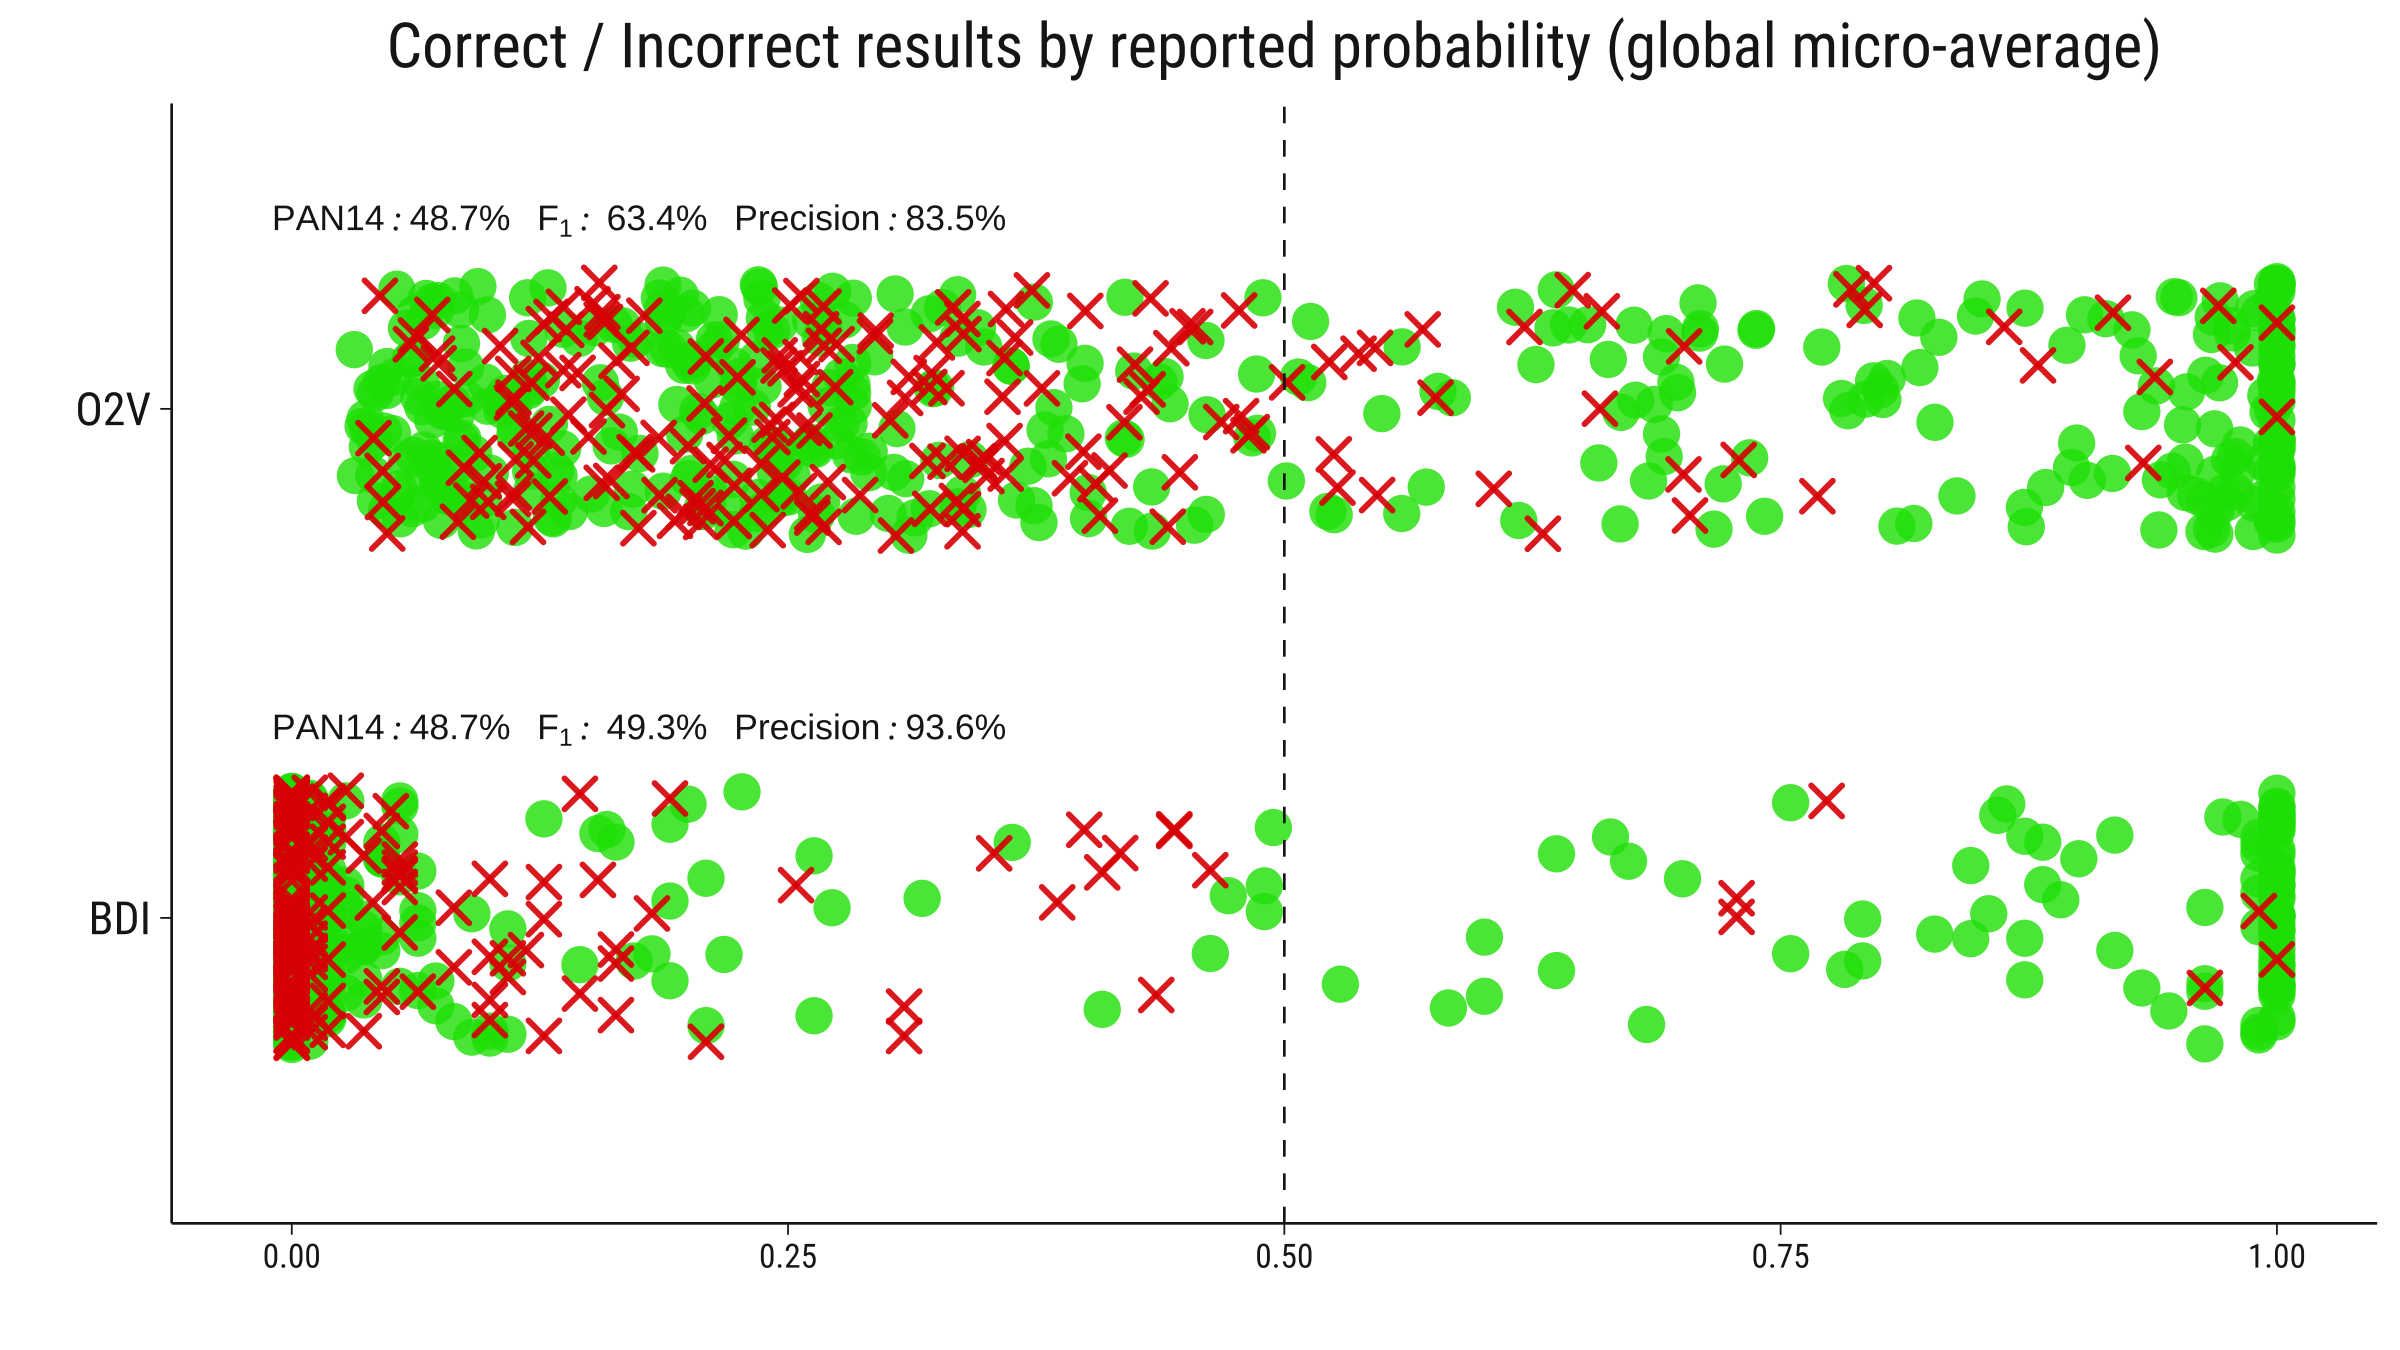

In [132]:
%%R -i df -h 4.5 -w 8 -u in -r 300
library(ggridges)
library(paletteer)
library(ggplot2)
library(dplyr)
library(showtext)
font_add_google("Roboto Condensed", "fnt")
showtext_auto()

fgcol <- '#1e1a1d'
bgcol <- 'white'

plt <- ggplot(data=df,aes(proba,y=classif,fill=tfu,color=tfu, shape=tfu)) +
coord_cartesian(clip = "off") +
geom_jitter(data=filter(df,tfu=='T'),size=3.2, stroke=1.5, alpha=0.8, width=0.0, height=0.25, color='#00e000',shape=16) +
geom_jitter(data=filter(df,tfu=='F'),size=2.8, stroke=1.0, alpha=0.9, width=0.0, height=0.25,color='#e00000',shape=4) +
annotate('text',hjust=0,x=-0.01,y=2.37, label="PAN14: 48.7*'%'~~~F[1]:~63.4*'%'~~~Precision: 83.5*'%'", color=fgcol, size=3, parse=TRUE) +
annotate('text', hjust=0,x=-0.01,y=1.37, label="PAN14: 48.7*'%'~~~F[1]:~49.3*'%'~~~Precision: 93.6*'%'", color=fgcol, size=3, parse=TRUE) +

geom_vline(xintercept=0.5, colour=fgcol, linetype='dashed', size=0.3) +
scale_fill_manual(values=c('red','#63a152','lightblue'))+
scale_color_manual(values=c('red','#63a152','lightblue'))+
scale_shape_manual(values=c(4,16,1)) +
theme_bw() +
xlab("") +
ylab("") +
ggtitle("Correct / Incorrect results by reported probability (global micro-average)") +
theme(
    panel.border = element_blank(),
    legend.position='none',
    panel.background = element_rect(fill = bgcol,color=bgcol),
    plot.background = element_rect(fill = bgcol,color=bgcol),
    plot.title = element_text(hjust = 0.5, size=15, family="fnt", color=fgcol),
    axis.line.x=element_line(linewidth=0.3,color=fgcol),
    axis.line.y=element_line(linewidth=0.3,color=fgcol),
    axis.ticks.x=element_line(linewidth=0.2,color=fgcol),
    axis.ticks.y=element_line(linewidth=0.2,color=fgcol),
    axis.text.x=element_text(size=8, family="fnt", color=fgcol),
    axis.text.y=element_text(size=11, family="fnt", color=fgcol),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
)

# fn <- "~/papers/bdi-paper/paper/figures/bdi_o2v.pdf"
# ggsave(fn, dpi=600, width=8, height=4.5)

plt
